In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cross_validation, metrics
import tensorflow as tf

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# run environment

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.4)
sess_config = tf.ConfigProto(gpu_options=gpu_options)

# label

In [3]:
labels = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '8':'application', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

fault_label = {'0':'file', '1':'network', '2':'service', '3':'database', '4':'communication', '5':'memory', '6':'driver', 
    '7':'system', '9':'io', '10':'others', '11':'security', '12':'disk', '13':'processor'}

# load data

In [4]:
def one_hot(y):
    y = y.reshape(len(y))
    n_values = np.max(y) + 1
    return np.eye(n_values)[np.array(y, dtype=np.int32)]  # Returns FLOATS


def load_X(X_path):
    X_list = []
    file = open(X_path, 'r')
    # Read dataset from disk, dealing with text files' syntax
    X_signal = [np.array(item, dtype=np.float32) for item in [
               line.strip().split('\t') for line in file]]
    X_list.append(X_signal)
    file.close()
    return np.transpose(np.array(X_list), (1, 2, 0))


# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array([elem for elem in [line.strip().split('\t') for line in file]], 
                  dtype=np.int32)
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return one_hot(y_-1)


dataset_path = "../data_msg_type/"
trainX_path = dataset_path + "semantic_train_x.txt"
trainY_path = dataset_path + "semantic_train_y.txt"
testX_path = dataset_path + "semantic_test_x.txt"
testY_path = dataset_path + "semantic_test_y.txt"


train_x = load_X(trainX_path)
train_y = load_y(trainY_path)
test_x = load_X(testX_path)
test_y = load_y(testY_path)

train_x = train_x.reshape(len(train_x), 10, 14, 1)
test_x = test_x.reshape(len(test_x), 10, 14, 1)

'''
# Separate our training data into test and training.
print("Separating data into 80% training set & 20% test set...")
train_x, test_x, train_y, test_y = cross_validation.train_test_split(
    x, y, test_size=0.2, random_state=33)#add random state here...
'''

print("Dataset separated.\n")
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

Dataset separated.

((80000, 10, 14, 1), (80000, 14), (20000, 10, 14, 1), (20000, 14))


# define parameters

In [5]:
learning_rate = 0.0001
training_iters = 16000000
batch_size = 1000
display_step = 20000

# Network Parameters
input_height = 10
input_width = 14
num_channels = 1
n_classes = 14
dropout = 0.75 # Dropout, probability to keep units

# network config

In [7]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 10, 14, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)
    print(conv1.shape)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)
    print(conv2.shape)
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)
    print(conv3.shape)

    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    
    # Fully connected layer
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    print(fc1.shape)
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    print(fc2.shape)

    # Output, class prediction
    fc3 = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    print(fc3.shape)
    return fc3

# Store layers weight & bias
weights = {
    # 3x4 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 4, 1, 32])),
    # 3x4 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 4, 32, 64])),
    # 3x4 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 4, 64, 64])),
    # fully connected, 2*2*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*64, 1024])),
    # fully connected, 1024 inputs, 512 outputs
    'wd2': tf.Variable(tf.random_normal([1024, 512])),
    # 512 inputs, 14outputs (class prediction)
    'out': tf.Variable(tf.random_normal([512, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bc3': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'bd2': tf.Variable(tf.random_normal([512])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# build model

In [8]:
x = tf.placeholder(tf.float32, [None,input_height,input_width,num_channels])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

(?, 5, 7, 32)
(?, 3, 4, 64)
(?, 2, 2, 64)
(?, 1024)
(?, 512)
(?, 14)


# train and test

In [9]:
def extract_batch_size(_train, step, batch_size):   
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data.    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 
    return batch_s


test_losses = []
test_accuracies = []
test_predictions = []
train_losses = []
train_accuracies = []


init = tf.global_variables_initializer()
with tf.Session(config=sess_config) as sess:
    sess.run(init)
    
    step = 1
    # Keep training until reach max iterations
    while step * batch_size <= training_iters:
        batch_xs = extract_batch_size(train_x, step, batch_size)
        batch_ys = extract_batch_size(train_y, step, batch_size)

        # Fit training using batch data
        _, loss, acc = sess.run([optimizer, cost, accuracy],
                       feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})

        train_losses.append(loss)
        train_accuracies.append(acc)  
        
        
        batch_xt = extract_batch_size(test_x, step, batch_size)
        batch_yt = extract_batch_size(test_y, step, batch_size)
    
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        test_predict, test_loss, test_acc = sess.run([pred, cost, accuracy], 
                                            feed_dict={x: batch_xt, y: batch_yt, keep_prob: 1.})
        
        test_predictions.append(np.argmax(test_predict, axis=1))
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_step == 0) or (step == 1) \
            or (step * batch_size > training_iters):

            print("Training epochs #" + str(step*batch_size) + \
                  ": Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))
        
            print("Performance on test set: " + "Training epochs #" + str(step*batch_size) +\
                  ", Batch Loss = {}".format(test_loss) + ", Accuracy = {}".format(test_acc))
        step += 1

    print("Optimization Finished!")

Training epochs #1000: Batch Loss = 4828300.000000, Accuracy = 0.0649999976158
Performance on test set: Training epochs #1000, Batch Loss = 2916144.0, Accuracy = 0.131999999285
Training epochs #20000: Batch Loss = 3808327.750000, Accuracy = 0.0689999982715
Performance on test set: Training epochs #20000, Batch Loss = 2184159.5, Accuracy = 0.00400000018999
Training epochs #40000: Batch Loss = 2348011.000000, Accuracy = 0.0960000008345
Performance on test set: Training epochs #40000, Batch Loss = 518689.78125, Accuracy = 0.0100000007078
Training epochs #60000: Batch Loss = 1197258.500000, Accuracy = 0.342000007629
Performance on test set: Training epochs #60000, Batch Loss = 344480.75, Accuracy = 0.805000066757
Training epochs #80000: Batch Loss = 835515.062500, Accuracy = 0.564000070095
Performance on test set: Training epochs #80000, Batch Loss = 503158.84375, Accuracy = 0.805000066757
Training epochs #100000: Batch Loss = 3416112.250000, Accuracy = 0.070000000298
Performance on test s

Training epochs #920000: Batch Loss = 266386.468750, Accuracy = 0.606999993324
Performance on test set: Training epochs #920000, Batch Loss = 58890.7734375, Accuracy = 0.943000078201
Training epochs #940000: Batch Loss = 179735.375000, Accuracy = 0.726999998093
Performance on test set: Training epochs #940000, Batch Loss = 74073.7109375, Accuracy = 0.942999958992
Training epochs #960000: Batch Loss = 157800.046875, Accuracy = 0.77999997139
Performance on test set: Training epochs #960000, Batch Loss = 83345.3359375, Accuracy = 0.943000018597
Training epochs #980000: Batch Loss = 1138930.250000, Accuracy = 0.16400000453
Performance on test set: Training epochs #980000, Batch Loss = 58849.3164062, Accuracy = 0.942999958992
Training epochs #1000000: Batch Loss = 242070.718750, Accuracy = 0.597000002861
Performance on test set: Training epochs #1000000, Batch Loss = 54176.828125, Accuracy = 0.943000078201
Training epochs #1020000: Batch Loss = 174500.046875, Accuracy = 0.729000031948
Perfo

Training epochs #1820000: Batch Loss = 72228.773438, Accuracy = 0.782999992371
Performance on test set: Training epochs #1820000, Batch Loss = 30127.0234375, Accuracy = 0.943000018597
Training epochs #1840000: Batch Loss = 56322.054688, Accuracy = 0.835000038147
Performance on test set: Training epochs #1840000, Batch Loss = 35577.5546875, Accuracy = 0.943000078201
Training epochs #1860000: Batch Loss = 502835.468750, Accuracy = 0.234999999404
Performance on test set: Training epochs #1860000, Batch Loss = 20943.1972656, Accuracy = 0.942999958992
Training epochs #1880000: Batch Loss = 92665.640625, Accuracy = 0.735999941826
Performance on test set: Training epochs #1880000, Batch Loss = 19036.8828125, Accuracy = 0.942999958992
Training epochs #1900000: Batch Loss = 61039.371094, Accuracy = 0.805999994278
Performance on test set: Training epochs #1900000, Batch Loss = 27454.7558594, Accuracy = 0.943000018597
Training epochs #1920000: Batch Loss = 43712.109375, Accuracy = 0.862999975681


Training epochs #2720000: Batch Loss = 23793.152344, Accuracy = 0.884000003338
Performance on test set: Training epochs #2720000, Batch Loss = 13940.6025391, Accuracy = 0.943000078201
Training epochs #2740000: Batch Loss = 270126.375000, Accuracy = 0.309000045061
Performance on test set: Training epochs #2740000, Batch Loss = 8790.83300781, Accuracy = 0.961000025272
Training epochs #2760000: Batch Loss = 42586.035156, Accuracy = 0.768000006676
Performance on test set: Training epochs #2760000, Batch Loss = 8800.21386719, Accuracy = 0.961000025272
Training epochs #2780000: Batch Loss = 31404.253906, Accuracy = 0.842000007629
Performance on test set: Training epochs #2780000, Batch Loss = 10869.2363281, Accuracy = 0.954999983311
Training epochs #2800000: Batch Loss = 23544.292969, Accuracy = 0.892000079155
Performance on test set: Training epochs #2800000, Batch Loss = 12824.8779297, Accuracy = 0.955000042915
Training epochs #2820000: Batch Loss = 237781.937500, Accuracy = 0.312000006437

Training epochs #3620000: Batch Loss = 154089.781250, Accuracy = 0.370999962091
Performance on test set: Training epochs #3620000, Batch Loss = 4798.63964844, Accuracy = 0.961000025272
Training epochs #3640000: Batch Loss = 18761.410156, Accuracy = 0.833999991417
Performance on test set: Training epochs #3640000, Batch Loss = 4986.75097656, Accuracy = 0.960999965668
Training epochs #3660000: Batch Loss = 15706.943359, Accuracy = 0.895000040531
Performance on test set: Training epochs #3660000, Batch Loss = 6338.21386719, Accuracy = 0.961000025272
Training epochs #3680000: Batch Loss = 11557.116211, Accuracy = 0.909000039101
Performance on test set: Training epochs #3680000, Batch Loss = 7030.34619141, Accuracy = 0.961000025272
Training epochs #3700000: Batch Loss = 132766.562500, Accuracy = 0.384999990463
Performance on test set: Training epochs #3700000, Batch Loss = 4529.22216797, Accuracy = 0.961000025272
Training epochs #3720000: Batch Loss = 21533.171875, Accuracy = 0.835000038147

Training epochs #4520000: Batch Loss = 12551.675781, Accuracy = 0.863999962807
Performance on test set: Training epochs #4520000, Batch Loss = 2639.51733398, Accuracy = 0.961000084877
Training epochs #4540000: Batch Loss = 9786.260742, Accuracy = 0.915000081062
Performance on test set: Training epochs #4540000, Batch Loss = 3654.70556641, Accuracy = 0.961000025272
Training epochs #4560000: Batch Loss = 7864.483398, Accuracy = 0.931000113487
Performance on test set: Training epochs #4560000, Batch Loss = 3992.22753906, Accuracy = 0.961000025272
Training epochs #4580000: Batch Loss = 76285.109375, Accuracy = 0.477999985218
Performance on test set: Training epochs #4580000, Batch Loss = 1926.58190918, Accuracy = 0.982000052929
Training epochs #4600000: Batch Loss = 12991.776367, Accuracy = 0.861000061035
Performance on test set: Training epochs #4600000, Batch Loss = 2449.76123047, Accuracy = 0.961000025272
Training epochs #4620000: Batch Loss = 9821.853516, Accuracy = 0.909000039101
Perf

Training epochs #5420000: Batch Loss = 6114.404297, Accuracy = 0.92199999094
Performance on test set: Training epochs #5420000, Batch Loss = 1595.7142334, Accuracy = 0.967999994755
Training epochs #5440000: Batch Loss = 2882.696533, Accuracy = 0.953000068665
Performance on test set: Training epochs #5440000, Batch Loss = 1620.03747559, Accuracy = 0.968000054359
Training epochs #5460000: Batch Loss = 54056.671875, Accuracy = 0.517999947071
Performance on test set: Training epochs #5460000, Batch Loss = 1244.23059082, Accuracy = 0.990000009537
Training epochs #5480000: Batch Loss = 7647.965820, Accuracy = 0.901000082493
Performance on test set: Training epochs #5480000, Batch Loss = 1181.69909668, Accuracy = 0.983000040054
Training epochs #5500000: Batch Loss = 6179.470703, Accuracy = 0.928000092506
Performance on test set: Training epochs #5500000, Batch Loss = 1515.03942871, Accuracy = 0.967999994755
Training epochs #5520000: Batch Loss = 3394.535645, Accuracy = 0.948000013828
Performa

Training epochs #6320000: Batch Loss = 2400.911865, Accuracy = 0.963000059128
Performance on test set: Training epochs #6320000, Batch Loss = 693.822814941, Accuracy = 0.983000040054
Training epochs #6340000: Batch Loss = 31216.046875, Accuracy = 0.649999976158
Performance on test set: Training epochs #6340000, Batch Loss = 883.345092773, Accuracy = 0.991000056267
Training epochs #6360000: Batch Loss = 3385.213135, Accuracy = 0.936000049114
Performance on test set: Training epochs #6360000, Batch Loss = 814.730834961, Accuracy = 0.991000056267
Training epochs #6380000: Batch Loss = 2677.241211, Accuracy = 0.954999983311
Performance on test set: Training epochs #6380000, Batch Loss = 699.026611328, Accuracy = 0.990000069141
Training epochs #6400000: Batch Loss = 1016.379822, Accuracy = 0.974999964237
Performance on test set: Training epochs #6400000, Batch Loss = 656.418457031, Accuracy = 0.990000069141
Training epochs #6420000: Batch Loss = 28169.787109, Accuracy = 0.625
Performance on

Training epochs #7220000: Batch Loss = 19128.978516, Accuracy = 0.67199999094
Performance on test set: Training epochs #7220000, Batch Loss = 532.24206543, Accuracy = 0.990999996662
Training epochs #7240000: Batch Loss = 1888.568970, Accuracy = 0.948000073433
Performance on test set: Training epochs #7240000, Batch Loss = 487.671569824, Accuracy = 0.991000115871
Training epochs #7260000: Batch Loss = 1828.345093, Accuracy = 0.959000110626
Performance on test set: Training epochs #7260000, Batch Loss = 400.36126709, Accuracy = 0.991000056267
Training epochs #7280000: Batch Loss = 1135.890503, Accuracy = 0.96899998188
Performance on test set: Training epochs #7280000, Batch Loss = 365.904968262, Accuracy = 0.990999996662
Training epochs #7300000: Batch Loss = 18325.875000, Accuracy = 0.694999933243
Performance on test set: Training epochs #7300000, Batch Loss = 500.644104004, Accuracy = 0.991000056267
Training epochs #7320000: Batch Loss = 1552.261475, Accuracy = 0.949000000954
Performan

Training epochs #8120000: Batch Loss = 1374.612793, Accuracy = 0.957000076771
Performance on test set: Training epochs #8120000, Batch Loss = 259.040252686, Accuracy = 0.991000056267
Training epochs #8140000: Batch Loss = 753.196899, Accuracy = 0.977000057697
Performance on test set: Training epochs #8140000, Batch Loss = 209.074127197, Accuracy = 0.991000056267
Training epochs #8160000: Batch Loss = 686.882385, Accuracy = 0.981000006199
Performance on test set: Training epochs #8160000, Batch Loss = 188.789016724, Accuracy = 0.991000056267
Training epochs #8180000: Batch Loss = 10746.726562, Accuracy = 0.756000041962
Performance on test set: Training epochs #8180000, Batch Loss = 285.706939697, Accuracy = 0.991000056267
Training epochs #8200000: Batch Loss = 908.687927, Accuracy = 0.965000033379
Performance on test set: Training epochs #8200000, Batch Loss = 255.856018066, Accuracy = 0.991000056267
Training epochs #8220000: Batch Loss = 1012.487488, Accuracy = 0.97000002861
Performanc

Training epochs #9020000: Batch Loss = 673.551697, Accuracy = 0.980000078678
Performance on test set: Training epochs #9020000, Batch Loss = 113.146530151, Accuracy = 0.991000056267
Training epochs #9040000: Batch Loss = 236.209991, Accuracy = 0.983000099659
Performance on test set: Training epochs #9040000, Batch Loss = 95.7598724365, Accuracy = 0.991000056267
Training epochs #9060000: Batch Loss = 5944.528809, Accuracy = 0.808000028133
Performance on test set: Training epochs #9060000, Batch Loss = 124.133758545, Accuracy = 0.991000056267
Training epochs #9080000: Batch Loss = 562.712036, Accuracy = 0.968000054359
Performance on test set: Training epochs #9080000, Batch Loss = 125.442703247, Accuracy = 0.991000056267
Training epochs #9100000: Batch Loss = 792.645142, Accuracy = 0.976999998093
Performance on test set: Training epochs #9100000, Batch Loss = 90.3785705566, Accuracy = 0.991000056267
Training epochs #9120000: Batch Loss = 193.861755, Accuracy = 0.984000086784
Performance 

Training epochs #9920000: Batch Loss = 186.481827, Accuracy = 0.987999975681
Performance on test set: Training epochs #9920000, Batch Loss = 43.519493103, Accuracy = 0.996999979019
Training epochs #9940000: Batch Loss = 5702.529785, Accuracy = 0.824000000954
Performance on test set: Training epochs #9940000, Batch Loss = 45.6228179932, Accuracy = 0.997000098228
Training epochs #9960000: Batch Loss = 244.162262, Accuracy = 0.986999988556
Performance on test set: Training epochs #9960000, Batch Loss = 64.0898895264, Accuracy = 0.997000098228
Training epochs #9980000: Batch Loss = 291.466309, Accuracy = 0.985000014305
Performance on test set: Training epochs #9980000, Batch Loss = 51.4803543091, Accuracy = 0.996999979019
Training epochs #10000000: Batch Loss = 159.871368, Accuracy = 0.994000017643
Performance on test set: Training epochs #10000000, Batch Loss = 39.8628082275, Accuracy = 0.997000098228
Training epochs #10020000: Batch Loss = 4868.043457, Accuracy = 0.842999994755
Performan

Training epochs #10820000: Batch Loss = 2721.376953, Accuracy = 0.860999941826
Performance on test set: Training epochs #10820000, Batch Loss = 20.0340194702, Accuracy = 0.996999979019
Training epochs #10840000: Batch Loss = 119.567886, Accuracy = 0.992000043392
Performance on test set: Training epochs #10840000, Batch Loss = 18.8604507446, Accuracy = 0.997000098228
Training epochs #10860000: Batch Loss = 345.109070, Accuracy = 0.982999920845
Performance on test set: Training epochs #10860000, Batch Loss = 13.1473302841, Accuracy = 0.997000098228
Training epochs #10880000: Batch Loss = 66.099800, Accuracy = 0.994000077248
Performance on test set: Training epochs #10880000, Batch Loss = 5.89133214951, Accuracy = 0.996999979019
Training epochs #10900000: Batch Loss = 3220.730225, Accuracy = 0.863000035286
Performance on test set: Training epochs #10900000, Batch Loss = 14.6140727997, Accuracy = 0.996999979019
Training epochs #10920000: Batch Loss = 171.319702, Accuracy = 0.981000065804
P

Training epochs #11740000: Batch Loss = 116.461327, Accuracy = 0.993000030518
Performance on test set: Training epochs #11740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11760000: Batch Loss = 24.728453, Accuracy = 0.994000017643
Performance on test set: Training epochs #11760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11780000: Batch Loss = 1630.860229, Accuracy = 0.879999995232
Performance on test set: Training epochs #11780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11800000: Batch Loss = 156.593658, Accuracy = 0.98400002718
Performance on test set: Training epochs #11800000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11820000: Batch Loss = 110.731293, Accuracy = 0.986000061035
Performance on test set: Training epochs #11820000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #11840000: Batch Loss = 79.972160, Accuracy = 0.990000069141
Performance on test set: Training epochs #11840000, Batch L

Training epochs #12700000: Batch Loss = 93.050919, Accuracy = 0.991000056267
Performance on test set: Training epochs #12700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12720000: Batch Loss = 13.676899, Accuracy = 0.998000085354
Performance on test set: Training epochs #12720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12740000: Batch Loss = 844.540161, Accuracy = 0.916999936104
Performance on test set: Training epochs #12740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12760000: Batch Loss = 51.947327, Accuracy = 0.991000056267
Performance on test set: Training epochs #12760000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12780000: Batch Loss = 162.347687, Accuracy = 0.990999996662
Performance on test set: Training epochs #12780000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #12800000: Batch Loss = 23.990646, Accuracy = 0.998000025749
Performance on test set: Training epochs #12800000, Batch Los

Training epochs #13660000: Batch Loss = 83.439308, Accuracy = 0.994000077248
Performance on test set: Training epochs #13660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13680000: Batch Loss = 3.302011, Accuracy = 0.999000072479
Performance on test set: Training epochs #13680000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13700000: Batch Loss = 866.565552, Accuracy = 0.931000053883
Performance on test set: Training epochs #13700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13720000: Batch Loss = 97.717499, Accuracy = 0.981999993324
Performance on test set: Training epochs #13720000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13740000: Batch Loss = 179.848450, Accuracy = 0.989000022411
Performance on test set: Training epochs #13740000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #13760000: Batch Loss = 32.785530, Accuracy = 0.996000051498
Performance on test set: Training epochs #13760000, Batch Loss

Training epochs #14620000: Batch Loss = 28.902847, Accuracy = 0.997000098228
Performance on test set: Training epochs #14620000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14640000: Batch Loss = 3.262764, Accuracy = 0.998000025749
Performance on test set: Training epochs #14640000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14660000: Batch Loss = 385.484131, Accuracy = 0.944000005722
Performance on test set: Training epochs #14660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14680000: Batch Loss = 33.801235, Accuracy = 0.990999996662
Performance on test set: Training epochs #14680000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14700000: Batch Loss = 25.602695, Accuracy = 0.995000004768
Performance on test set: Training epochs #14700000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #14720000: Batch Loss = 9.031984, Accuracy = 0.997000098228
Performance on test set: Training epochs #14720000, Batch Loss =

Training epochs #15580000: Batch Loss = 16.794958, Accuracy = 0.998000144958
Performance on test set: Training epochs #15580000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15600000: Batch Loss = 8.312257, Accuracy = 0.997000098228
Performance on test set: Training epochs #15600000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15620000: Batch Loss = 282.024017, Accuracy = 0.960000038147
Performance on test set: Training epochs #15620000, Batch Loss = 0.0, Accuracy = 1.0
Training epochs #15640000: Batch Loss = 27.164040, Accuracy = 0.995000004768
Performance on test set: Training epochs #15640000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15660000: Batch Loss = 22.220686, Accuracy = 0.996000051498
Performance on test set: Training epochs #15660000, Batch Loss = 0.0, Accuracy = 1.00000011921
Training epochs #15680000: Batch Loss = 11.128137, Accuracy = 0.998000025749
Performance on test set: Training epochs #15680000, Batch Loss = 0.0, Acc

# performance visualization

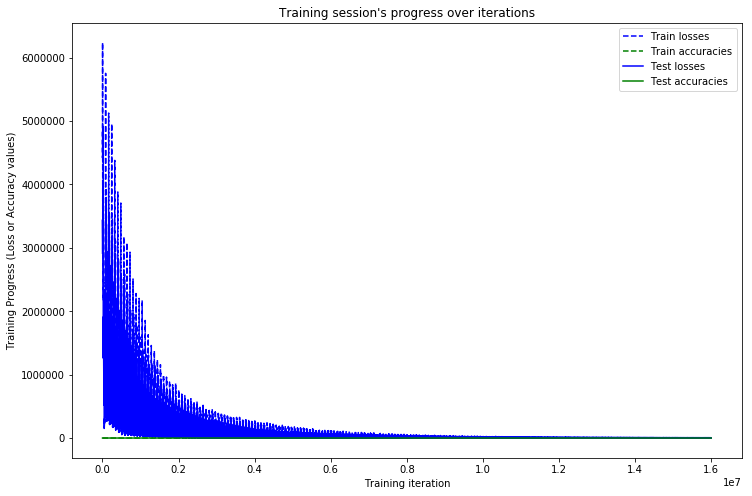

In [10]:
#font = {'family': 'Bitstream Vera Sans', 'weight': 'bold', 'size': 12}
#matplotlib.rc('font', **font)
width = 12
height = 8
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, 
                   (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses), "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(np.array(range(batch_size, 
                  len(test_losses)*batch_size, batch_size)), training_iters)
plt.plot(indep_test_axis, np.array(test_losses), "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=False)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')
plt.savefig('result/lstm_loss_accuracy.png')
plt.figure()
plt.show()

Best Testing Accuracy: 100.000011921%

Precision: 97.3384425299%
Recall: 97.28%
f1_score: 97.24096453%

Confusion Matrix:
[[    5    13     0     0     0     0     0     0     0     0     0     0
      0]
 [    0   783     0     0    27    28    38    11     0     0     0    24
      0]
 [    0     0   213     0     0     0     0     0     0     0     0     0
      0]
 [    0     2     0     0     0     0     0     0     0     0     0     0
      0]
 [    0    64     0     0  2803    10     0    11     0     0     0     3
      0]
 [    7    61     0     0     0   271     0     6     0     0     0     3
      0]
 [    0     7     0     0     0     0 14486     0     0     0     0     2
      0]
 [    0    64     0     0    44    54     0   367     0     0     0     6
      0]
 [    0     0     0     0     0     0     0     0   132     0     0     0
      0]
 [    0     0     0     0     0     0     0     0     0     2     0     2
      0]
 [    0     0     0     0     0     0     0     

/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


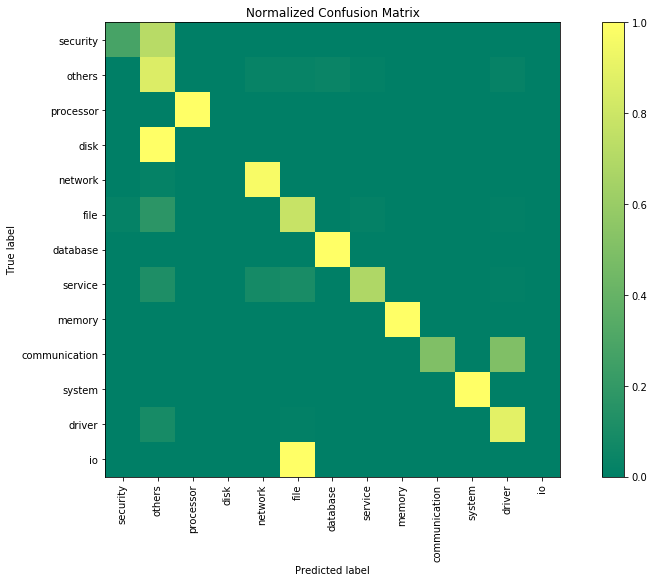

In [11]:
# Results
predictions = []
length = len(test_predictions)-20
for i in range(20):
    predictions.extend(test_predictions[length+i])

true_y = np.argmax(test_y, axis=1)

print("Best Testing Accuracy: {}%".format(100*max(test_accuracies)))

print("")
print("Precision: {}%".format(100*metrics.precision_score(
    true_y, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(true_y, 
    predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(true_y, 
    predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(true_y, predictions)
print(confusion_matrix)

# Plot: 
## cmap can be changed to many colors, (colormaps.Oranges,OrRd, etc)
def plot_CM(cm, title="Normalized Confusion Matrix", cmap=plt.cm.summer):
    width = 12
    height = 8
    plt.figure(figsize=(width, height))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(fault_label))
    plt.xticks(tick_marks, fault_label.values(), rotation=90)
    plt.yticks(tick_marks, fault_label.values())
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    
print(metrics.classification_report(
    true_y, predictions, target_names = list(labels.values())))

cm = confusion_matrix

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
plt.figure()
plot_CM(cm_normalized)